### 0. Load Dependencies

In [1]:
import numpy as np
import pickle
import time
from KNN_Shapley import get_VN, get_true_KNN, compute_KNN_shapley, compute_KNN_Asymmetric_Shapley, KNN_LOO, Logistic_LOO
from performance_plot import removing_sequential_data, adding_sequential_data, final_plot
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### 1. Load Data and Select Data Based on MC Values

In [2]:
# Load data
add_ratio = 0.1
n_samples = 10
num_permutations = 6000
m1, m2, m3, m4, m5, m6 = 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'

for i_split in range(n_samples):
    
    print('split', i_split+1)
    # Load data 
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1_trn = mydict['X_{}_trn'.format(m1)]
    y_m1_trn = mydict['y_{}_trn'.format(m1)]
    X_m1m2_trn = mydict['X_{}_{}_trn'.format(m1, m2)]
    y_m1m2_trn = mydict['y_{}_{}_trn'.format(m1, m2)]
    X_m3_trn = mydict['X_{}_trn'.format(m3)]
    y_m3_trn = mydict['y_{}_trn'.format(m3)]
    s_class_dic = {0: np.asarray(range(len(X_m1_trn))),
               1: np.asarray(range(len(X_m1_trn), len(X_m1m2_trn)))}
    
    # Load tree-mc-asv
    directory = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_1/'.format(i_split+1)
    with open(directory + 'tmc_asymmetric_shapley_model=Tree_metric=accuracy.pkl', 'rb') as fp:
        mc_asv_tree_dict = pickle.load(fp)
    mc_asv_tree = np.mean(mc_asv_tree_dict['marginals_tmc'][:num_permutations], axis=0)
    print('mc_asv_tree.shape', mc_asv_tree_dict['marginals_tmc'].shape,
          mc_asv_tree_dict['marginals_tmc'][:num_permutations].shape)
    
    seq_asv = np.argsort(mc_asv_tree)[::-1] # rank asv from high to low
    seq_asv_class0 = np.array([i for i in seq_asv if i in s_class_dic[0]])
    seq_asv_class1 = np.array([i for i in seq_asv if i in s_class_dic[1]])
    
    add_num = int(len(s_class_dic[1])*add_ratio)
    selected_idx_asv = np.concatenate((seq_asv_class0, seq_asv_class1[:add_num]))
    X_m1m2_trn_selected, y_m1m2_trn_selected = X_m1m2_trn[selected_idx_asv], y_m1m2_trn[selected_idx_asv]
    X_m1m2m3_trn_selected = np.concatenate((X_m1m2_trn_selected, X_m3_trn))
    y_m1m2m3_trn_selected = np.concatenate((y_m1m2_trn_selected, y_m3_trn))

    s_class_dic2 = {0: np.asarray(range(len(X_m1m2_trn_selected))),
                    1: np.asarray(range(len(X_m1m2_trn_selected), len(X_m1m2m3_trn_selected)))}

    mydict['X_m1m2_trn_selected'] = X_m1m2_trn_selected
    mydict['y_m1m2_trn_selected'] = y_m1m2_trn_selected
    mydict['X_m1m2m3_selected'] = X_m1m2m3_trn_selected
    mydict['y_m1m2m3_selected'] = y_m1m2m3_trn_selected
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "wb") as fp:
        pickle.dump(mydict, fp)

split 1
mc_asv_tree.shape (17800, 978) (6000, 978)
split 2
mc_asv_tree.shape (17450, 978) (6000, 978)
split 3
mc_asv_tree.shape (6850, 978) (6000, 978)
split 4
mc_asv_tree.shape (10950, 978) (6000, 978)
split 5
mc_asv_tree.shape (15800, 978) (6000, 978)
split 6
mc_asv_tree.shape (11550, 978) (6000, 978)
split 7
mc_asv_tree.shape (11650, 978) (6000, 978)
split 8
mc_asv_tree.shape (26100, 978) (6000, 978)
split 9
mc_asv_tree.shape (7300, 978) (6000, 978)
split 10
mc_asv_tree.shape (8650, 978) (6000, 978)


In [3]:
X_m3_trn.shape[0]

334

In [4]:
X_m1_trn.shape, X_m1m2_trn_selected.shape

((523, 27), (568, 27))

### 2. Sanity check: compute KNN-SV and KNN-ASV for experiment 2

In [5]:
m1, m2, m3, m4, m5, m6 = 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
K = 5

In [6]:
for i_split in range(n_samples):
    
    print('split', i_split+1)
    
    # Load data
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1m2_trn_selected = mydict['X_m1m2_trn_selected']  
    y_m1m2_trn_selected = mydict['y_m1m2_trn_selected'] 
    X_m1m2m3_trn_selected = mydict['X_m1m2m3_selected']
    y_m1m2m3_trn_selected = mydict['y_m1m2m3_selected']
    X_m1m2m3_val = mydict['X_{}_{}_{}_val'.format(m1, m2, m3)]
    y_m1m2m3_val = mydict['y_{}_{}_{}_val'.format(m1, m2, m3)]
    
    s_class_dic2 = {0: np.asarray(range(len(X_m1m2_trn_selected))),
                    1: np.asarray(range(len(X_m1m2_trn_selected), len(X_m1m2m3_trn_selected)))}

    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_split+1)
    
    # Train knn classifier
    x_m1m2m3_knn_gt = get_true_KNN(X_m1m2m3_trn_selected, X_m1m2m3_val)  
    
    # Compute KNN shapley
    start = time.time()
    knn_shaps = compute_KNN_shapley(y_m1m2m3_trn_selected, x_m1m2m3_knn_gt, y_m1m2m3_val, K)
    end = time.time()
    print("Time to compute the exact symmetric shapley values for all data:", end - start)
    np.save(directory2 + 'm1m2m3_sv_asv-selected_experiment2_K={}'.format(K), knn_shaps)
    
    # Compute KNN asymmetric shapley
    start = time.time()
    knn_asym_shaps = compute_KNN_Asymmetric_Shapley(y_m1m2m3_trn_selected, x_m1m2m3_knn_gt, 
                                                    y_m1m2m3_val, K, s_class_dic2)
    end = time.time()
    print("Time to compute the exact asymmetric shapley values for all data:", end - start)
    np.save(directory2 + 'm1m2m3_asv_asv-selected_experiment2_K={}'.format(K), knn_asym_shaps)
    
    # Compute the KNN LOO values
    start = time.time()
    knn_loos = KNN_LOO(X_m1m2m3_trn_selected, y_m1m2m3_trn_selected, X_m1m2m3_val, 
                       y_m1m2m3_val, K, False)
    np.save(directory2 + 'm1m2m3_loo_asv-selected_experiment2_K={}'.format(K), knn_loos)

split 1


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 675.94it/s]


Time to compute the exact symmetric shapley values for all data: 0.8362410068511963


100%|█████████████████████████████████████████| 564/564 [00:05<00:00, 94.95it/s]


Time to compute the exact asymmetric shapley values for all data: 8.198768138885498
split 2


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 667.27it/s]


Time to compute the exact symmetric shapley values for all data: 0.8465790748596191


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 92.92it/s]


Time to compute the exact asymmetric shapley values for all data: 8.387215852737427
split 3


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 662.98it/s]


Time to compute the exact symmetric shapley values for all data: 0.8516848087310791


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 93.92it/s]


Time to compute the exact asymmetric shapley values for all data: 8.327692031860352
split 4


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 665.33it/s]


Time to compute the exact symmetric shapley values for all data: 0.8491470813751221


100%|█████████████████████████████████████████| 564/564 [00:05<00:00, 95.06it/s]


Time to compute the exact asymmetric shapley values for all data: 8.261563062667847
split 5


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 664.30it/s]


Time to compute the exact symmetric shapley values for all data: 0.8500640392303467


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 93.35it/s]


Time to compute the exact asymmetric shapley values for all data: 8.364304780960083
split 6


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 664.12it/s]


Time to compute the exact symmetric shapley values for all data: 0.8502037525177002


100%|█████████████████████████████████████████| 564/564 [00:05<00:00, 94.45it/s]


Time to compute the exact asymmetric shapley values for all data: 8.295119047164917
split 7


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 657.88it/s]


Time to compute the exact symmetric shapley values for all data: 0.8582851886749268


100%|█████████████████████████████████████████| 564/564 [00:05<00:00, 94.67it/s]


Time to compute the exact asymmetric shapley values for all data: 8.275361061096191
split 8


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 665.36it/s]


Time to compute the exact symmetric shapley values for all data: 0.8487510681152344


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 92.64it/s]


Time to compute the exact asymmetric shapley values for all data: 8.406765699386597
split 9


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 659.19it/s]


Time to compute the exact symmetric shapley values for all data: 0.8567981719970703


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 93.09it/s]


Time to compute the exact asymmetric shapley values for all data: 8.366627216339111
split 10


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 656.09it/s]


Time to compute the exact symmetric shapley values for all data: 0.8606629371643066


100%|█████████████████████████████████████████| 564/564 [00:06<00:00, 92.09it/s]


Time to compute the exact asymmetric shapley values for all data: 8.468776941299438


### 3. Sanity check: check efficiency axiom for KNN-ASV values

In [7]:
for i_split in range(n_samples):
    
    print('split', i_split+1)
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1m2_trn_selected = mydict['X_m1m2_trn_selected']  
    y_m1m2_trn_selected = mydict['y_m1m2_trn_selected'] 
    X_m1m2m3_trn_selected = mydict['X_m1m2m3_selected']
    y_m1m2m3_trn_selected = mydict['y_m1m2m3_selected']
    X_m1m2m3_val = mydict['X_{}_{}_{}_val'.format(m1, m2, m3)]
    y_m1m2m3_val = mydict['y_{}_{}_{}_val'.format(m1, m2, m3)]
    
    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_split+1)
    
    # Sanity check: verify the efficiency axiom
    m1m2m3_sv = np.load(directory2 + 'm1m2m3_sv_asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_asv = np.load(directory2 + 'm1m2m3_asv_asv-selected_experiment2_K={}.npy'.format(K))
    
    m1m2_asv = m1m2m3_asv[s_class_dic2[0]]
    m3_asv = m1m2m3_asv[s_class_dic2[1]]

    vn_m1m2m3 = get_VN(X_m1m2m3_trn_selected, X_m1m2m3_val, y_m1m2m3_trn_selected, y_m1m2m3_val, K)
    print(' ')
    print('V(N) of previous and current month data points:', vn_m1m2m3)
    print('sum of shapley value of previous and current month data points:', m1m2m3_sv.sum())

    vn_m1m2 = get_VN(X_m1m2_trn_selected, X_m1m2m3_val, y_m1m2_trn_selected, y_m1m2m3_val, K)
    print(' ')
    print('V(N) of previous month data points:', vn_m1m2)
    print('sum of asymmetric shapley value of previous month data points:', m1m2_asv.sum())

    vn_m3 = vn_m1m2m3 - vn_m1m2
    print(' ')
    print('V(N) of current month data points:', vn_m3)
    print('sum of asymmetric shapley value of current month data points:', m3_asv.sum())
    print(' ')
    print(' ')

split 1


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 749.37it/s]


 
V(N) of previous and current month data points: 0.8308510638297886
sum of shapley value of previous and current month data points: 0.8308510638297871


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1217.81it/s]


 
V(N) of previous month data points: 0.7929078014184404
sum of asymmetric shapley value of previous month data points: 0.793262411347518
 
V(N) of current month data points: 0.037943262411348155
sum of asymmetric shapley value of current month data points: 0.03758865248226726
 
 
split 2


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 755.75it/s]


 
V(N) of previous and current month data points: 0.8187943262411358
sum of shapley value of previous and current month data points: 0.8187943262411346


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1220.85it/s]


 
V(N) of previous month data points: 0.7868794326241144
sum of asymmetric shapley value of previous month data points: 0.7868794326241135
 
V(N) of current month data points: 0.03191489361702138
sum of asymmetric shapley value of current month data points: 0.03191489361702034
 
 
split 3


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 754.77it/s]


 
V(N) of previous and current month data points: 0.8131205673758879
sum of shapley value of previous and current month data points: 0.8131205673758864


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1220.49it/s]


 
V(N) of previous month data points: 0.7893617021276605
sum of asymmetric shapley value of previous month data points: 0.7890070921985817
 
V(N) of current month data points: 0.023758865248227345
sum of asymmetric shapley value of current month data points: 0.024113475177308538
 
 
split 4


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 761.27it/s]


 
V(N) of previous and current month data points: 0.8251773049645412
sum of shapley value of previous and current month data points: 0.825177304964539


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1217.54it/s]


 
V(N) of previous month data points: 0.7865248226950365
sum of asymmetric shapley value of previous month data points: 0.7865248226950357
 
V(N) of current month data points: 0.038652482269504684
sum of asymmetric shapley value of current month data points: 0.03865248226949634
 
 
split 5


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 766.49it/s]


 
V(N) of previous and current month data points: 0.8255319148936183
sum of shapley value of previous and current month data points: 0.8255319148936171


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1220.07it/s]


 
V(N) of previous month data points: 0.7960992907801426
sum of asymmetric shapley value of previous month data points: 0.7960992907801419
 
V(N) of current month data points: 0.02943262411347569
sum of asymmetric shapley value of current month data points: 0.029432624113475563
 
 
split 6


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 766.90it/s]


 
V(N) of previous and current month data points: 0.8269503546099309
sum of shapley value of previous and current month data points: 0.826950354609929


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1216.42it/s]


 
V(N) of previous month data points: 0.7819148936170224
sum of asymmetric shapley value of previous month data points: 0.7819148936170214
 
V(N) of current month data points: 0.04503546099290856
sum of asymmetric shapley value of current month data points: 0.04503546099290564
 
 
split 7


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 766.18it/s]


 
V(N) of previous and current month data points: 0.8141843971631217
sum of shapley value of previous and current month data points: 0.8141843971631206


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1219.28it/s]


 
V(N) of previous month data points: 0.7826241134751785
sum of asymmetric shapley value of previous month data points: 0.7826241134751775
 
V(N) of current month data points: 0.03156028368794328
sum of asymmetric shapley value of current month data points: 0.031560283687940095
 
 
split 8


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 763.24it/s]


 
V(N) of previous and current month data points: 0.8085106382978736
sum of shapley value of previous and current month data points: 0.8085106382978722


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1219.92it/s]


 
V(N) of previous month data points: 0.7726950354609944
sum of asymmetric shapley value of previous month data points: 0.7719858156028371
 
V(N) of current month data points: 0.035815602836879235
sum of asymmetric shapley value of current month data points: 0.03652482269503232
 
 
split 9


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 767.24it/s]


 
V(N) of previous and current month data points: 0.8148936170212786
sum of shapley value of previous and current month data points: 0.8148936170212766


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1219.32it/s]


 
V(N) of previous month data points: 0.7808510638297885
sum of asymmetric shapley value of previous month data points: 0.7812056737588654
 
V(N) of current month data points: 0.03404255319149008
sum of asymmetric shapley value of current month data points: 0.03368794326240968
 
 
split 10


100%|████████████████████████████████████████| 564/564 [00:00<00:00, 771.26it/s]


 
V(N) of previous and current month data points: 0.822340425531916
sum of shapley value of previous and current month data points: 0.8223404255319148


100%|███████████████████████████████████████| 564/564 [00:00<00:00, 1229.89it/s]

 
V(N) of previous month data points: 0.7960992907801423
sum of asymmetric shapley value of previous month data points: 0.796099290780142
 
V(N) of current month data points: 0.026241134751773698
sum of asymmetric shapley value of current month data points: 0.026241134751771623
 
 


### 4. Performance Plot: KNN model

split 1
Removing low value sequential data experiment started...


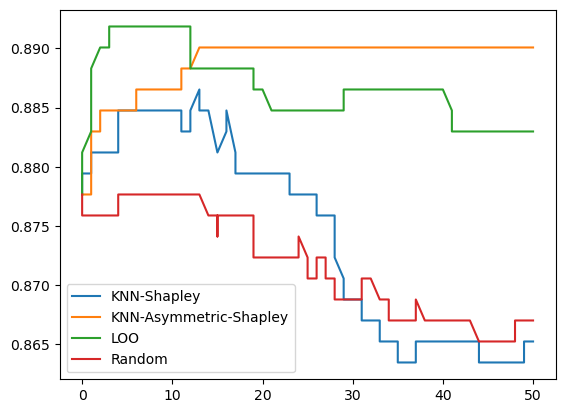

Removing high value sequential data experiment started...


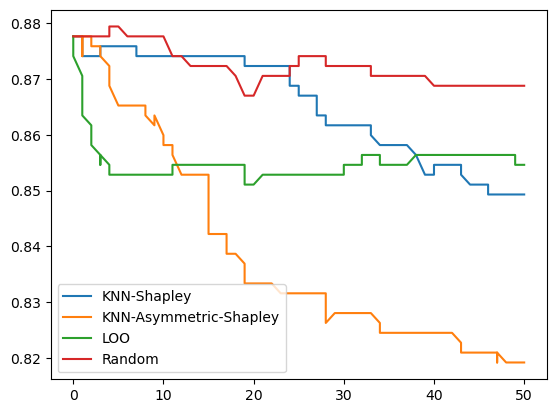

Adding low value sequential data experiment started...


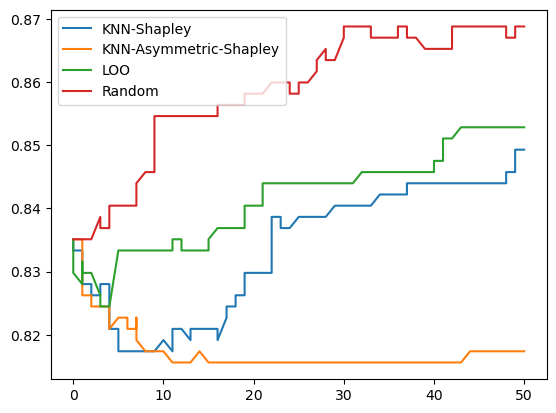

Adding high value sequential data experiment started...


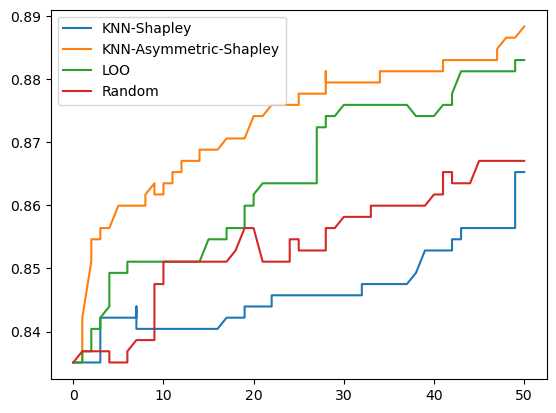

split 2
Removing low value sequential data experiment started...


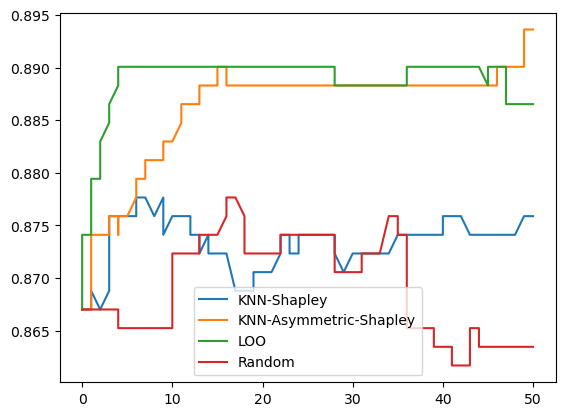

Removing high value sequential data experiment started...


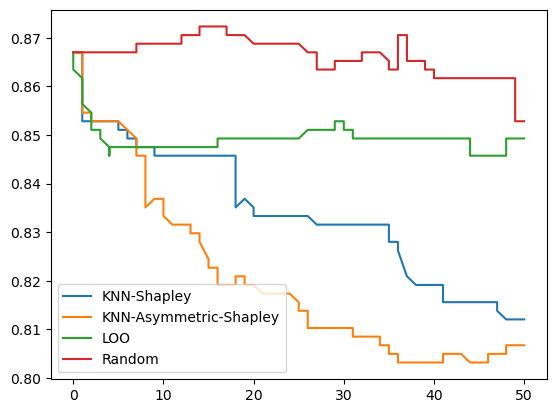

Adding low value sequential data experiment started...


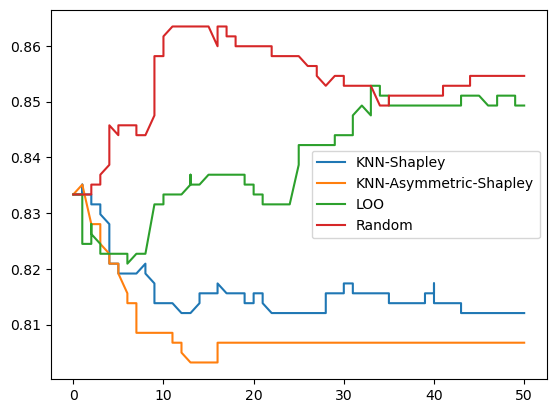

Adding high value sequential data experiment started...


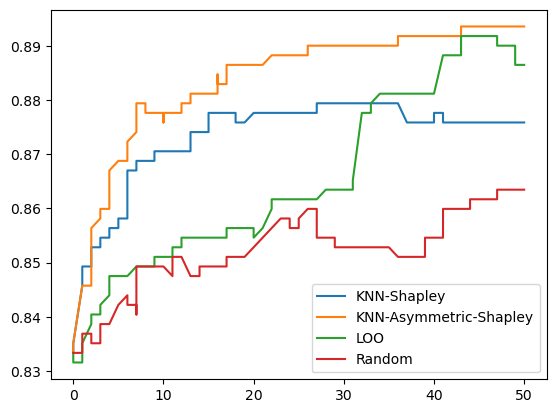

split 3
Removing low value sequential data experiment started...


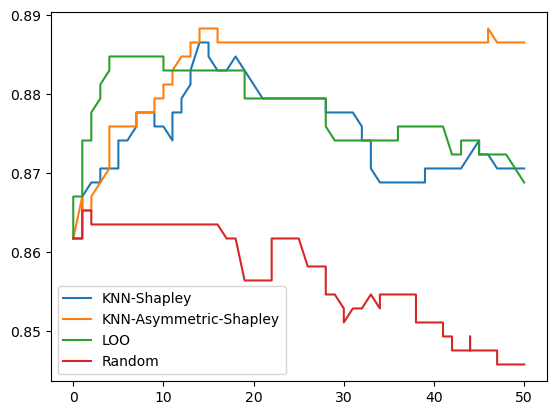

Removing high value sequential data experiment started...


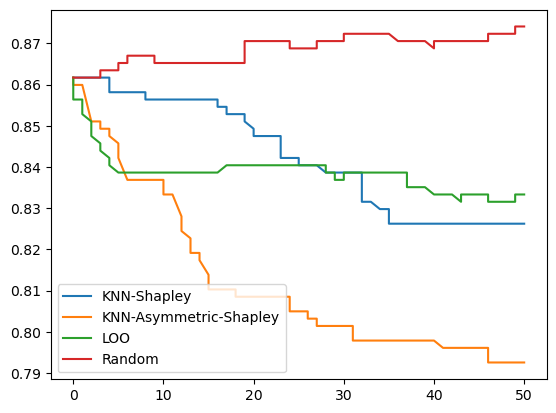

Adding low value sequential data experiment started...


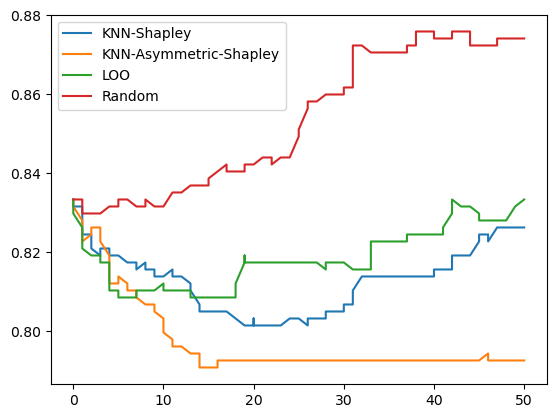

Adding high value sequential data experiment started...


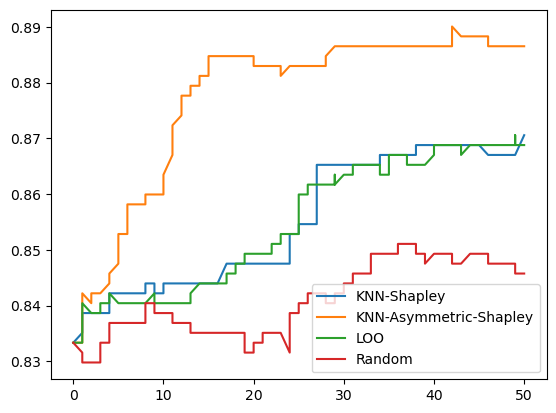

split 4
Removing low value sequential data experiment started...


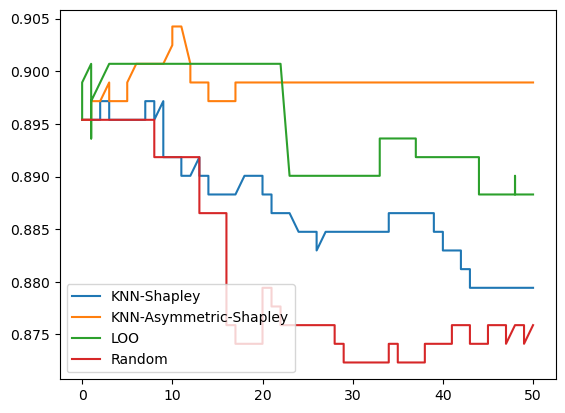

Removing high value sequential data experiment started...


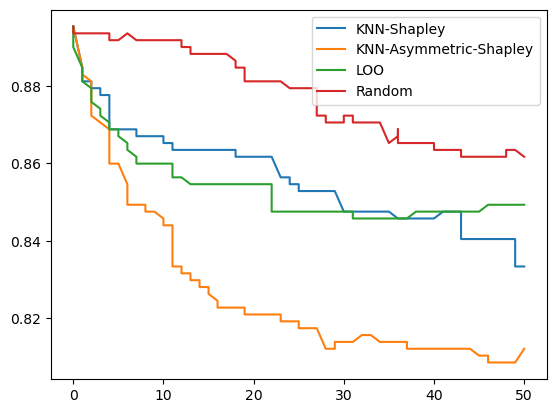

Adding low value sequential data experiment started...


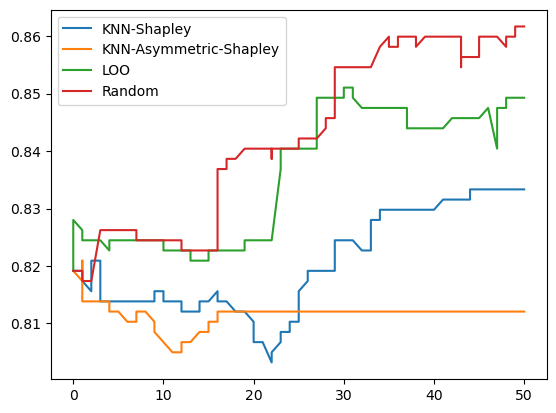

Adding high value sequential data experiment started...


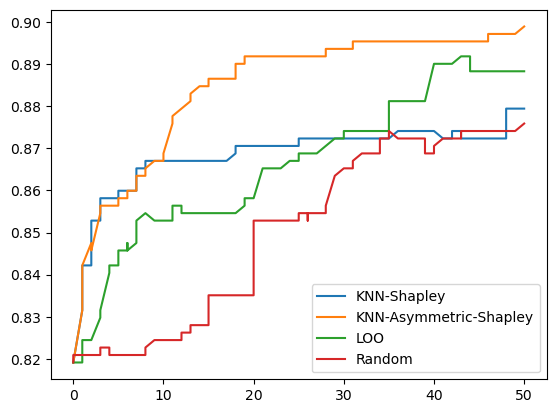

split 5
Removing low value sequential data experiment started...


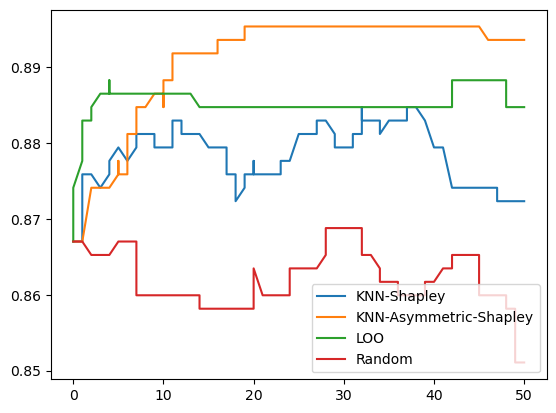

Removing high value sequential data experiment started...


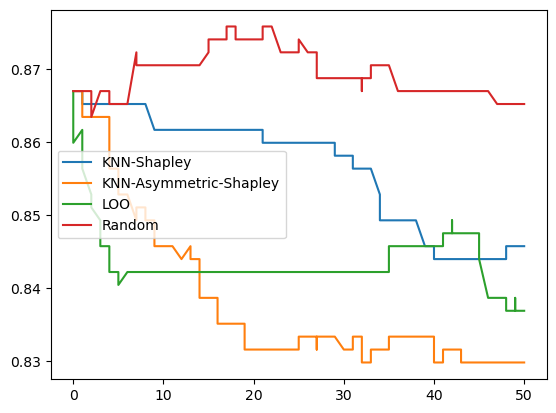

Adding low value sequential data experiment started...


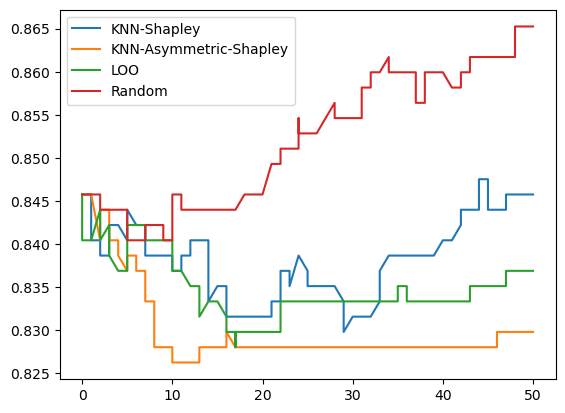

Adding high value sequential data experiment started...


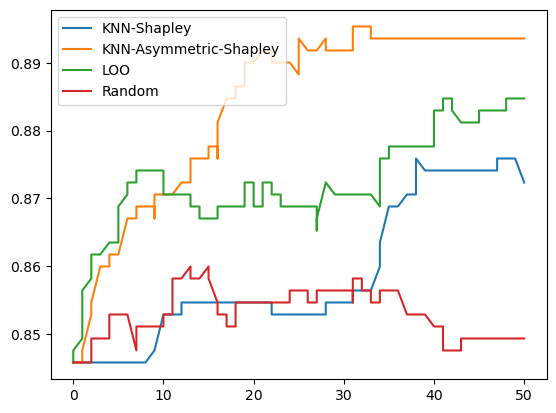

split 6
Removing low value sequential data experiment started...


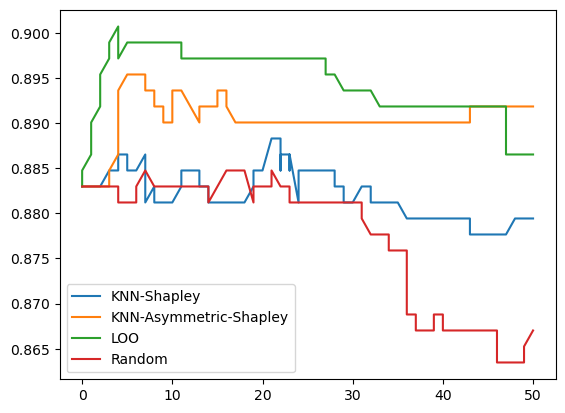

Removing high value sequential data experiment started...


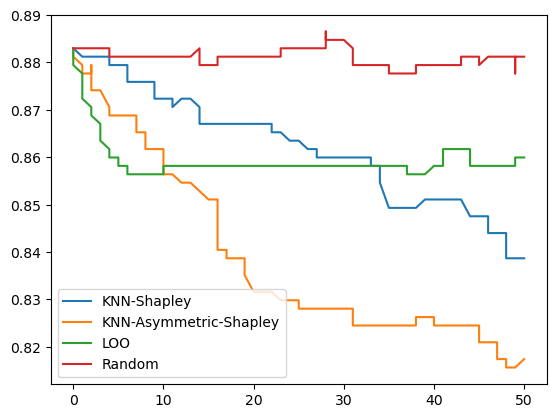

Adding low value sequential data experiment started...


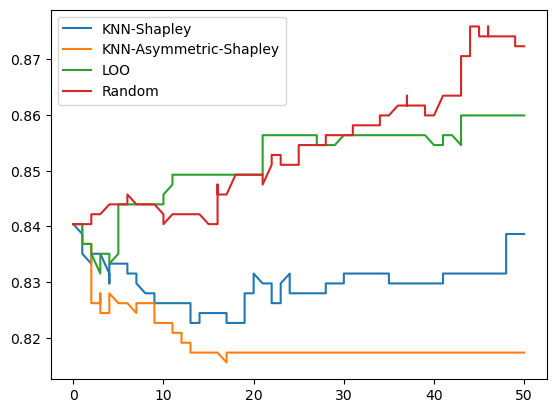

Adding high value sequential data experiment started...


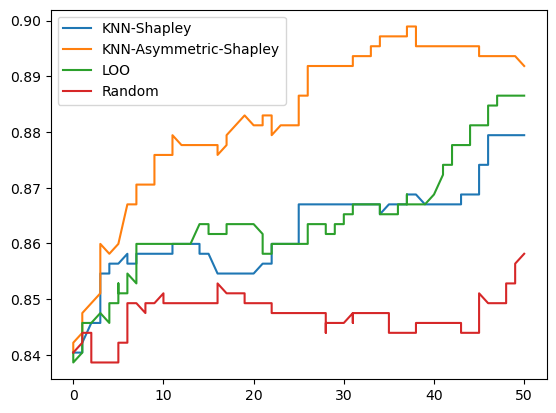

split 7
Removing low value sequential data experiment started...


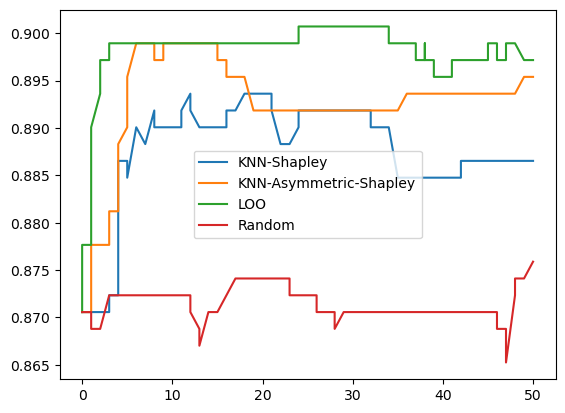

Removing high value sequential data experiment started...


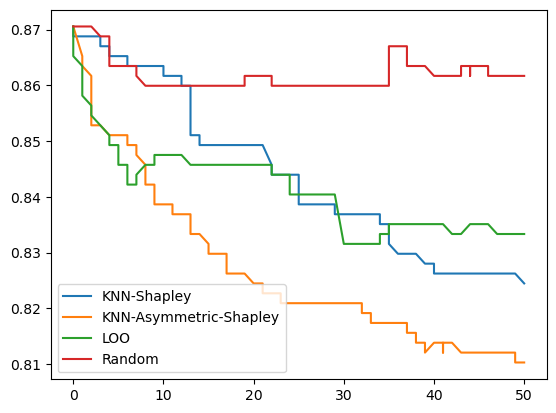

Adding low value sequential data experiment started...


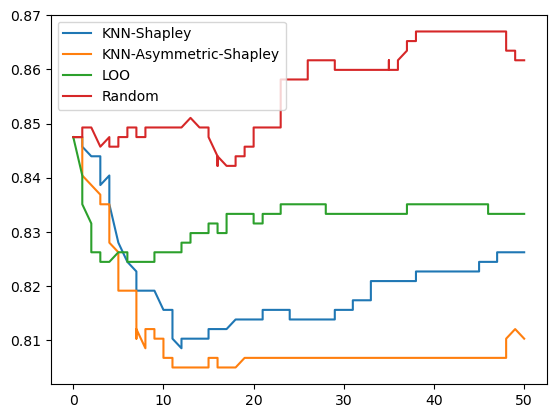

Adding high value sequential data experiment started...


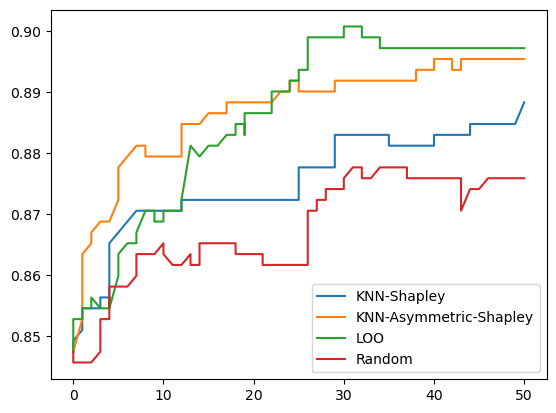

split 8
Removing low value sequential data experiment started...


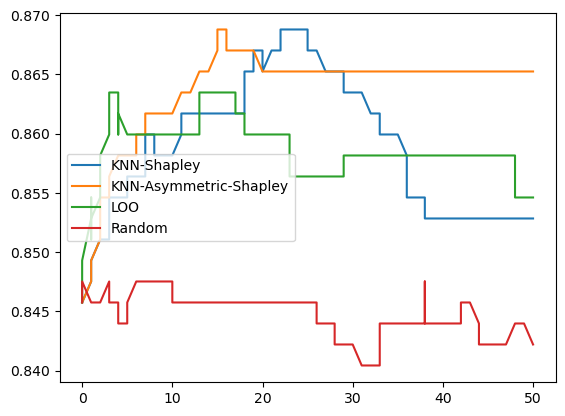

Removing high value sequential data experiment started...


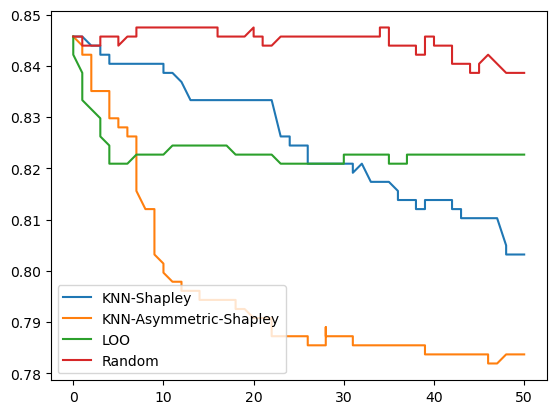

Adding low value sequential data experiment started...


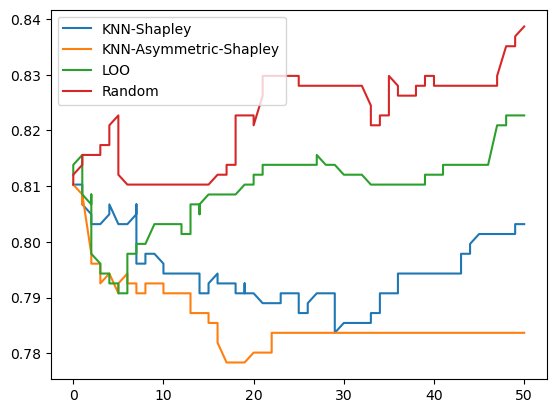

Adding high value sequential data experiment started...


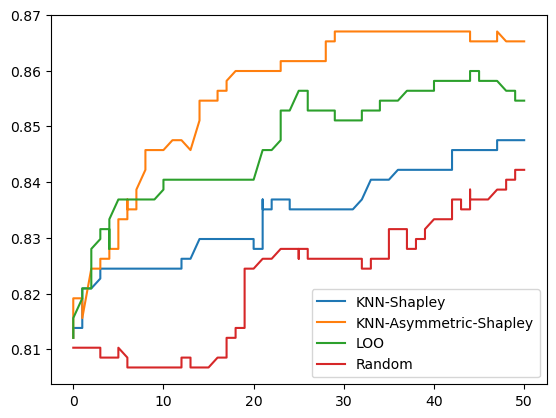

split 9
Removing low value sequential data experiment started...


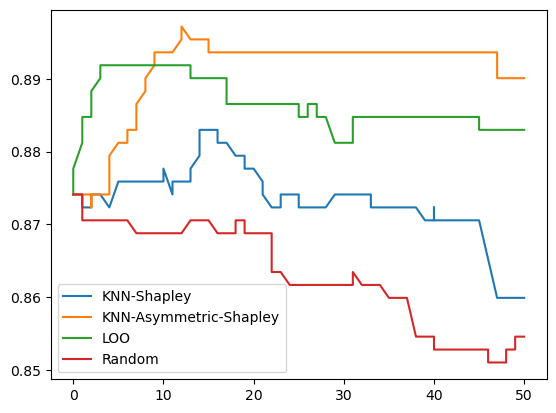

Removing high value sequential data experiment started...


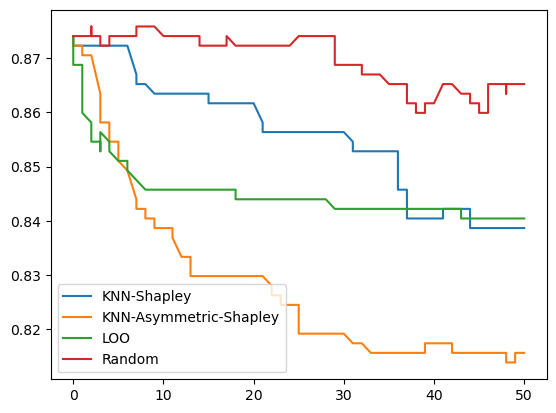

Adding low value sequential data experiment started...


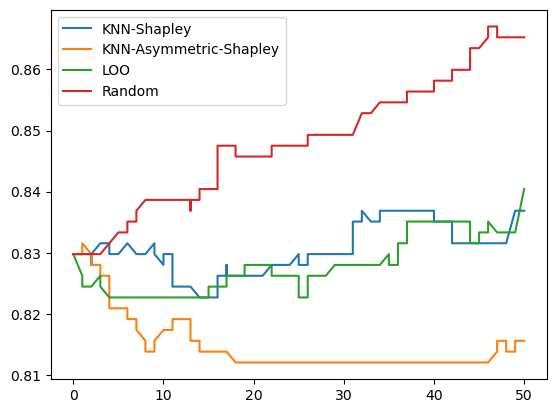

Adding high value sequential data experiment started...


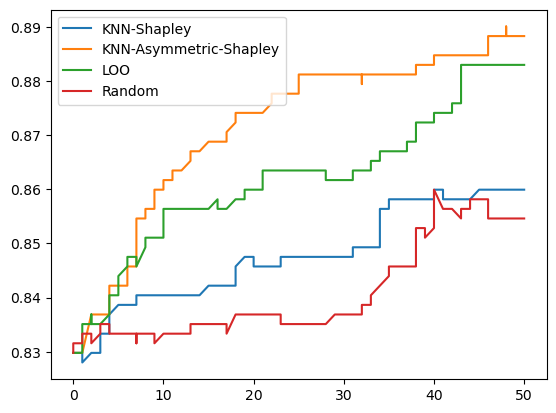

split 10
Removing low value sequential data experiment started...


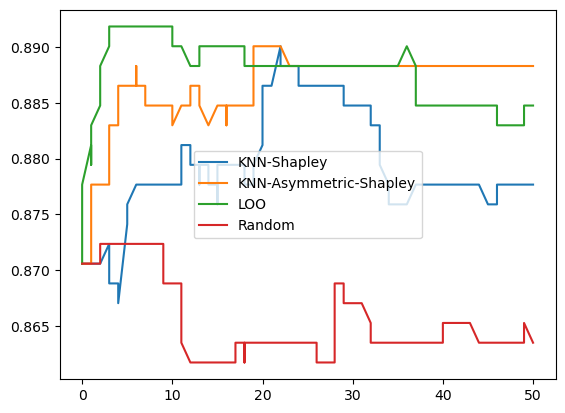

Removing high value sequential data experiment started...


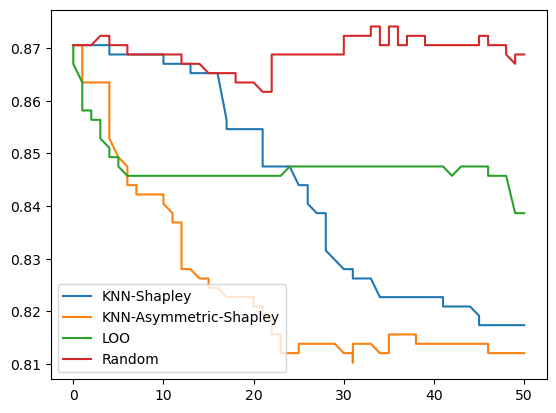

Adding low value sequential data experiment started...


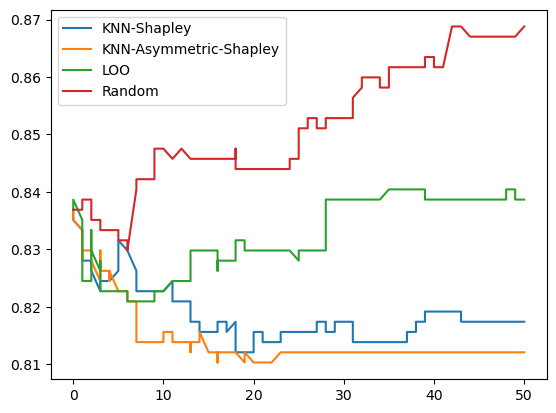

Adding high value sequential data experiment started...


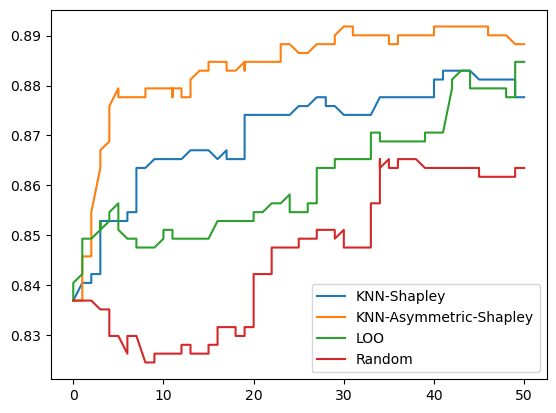

In [8]:
# Performance plot

from sklearn.neighbors import KNeighborsClassifier as KNN
model = KNN(n_neighbors=K, weights='uniform')

for i_split in range(n_samples):
    
    print('split', i_split+1)
    
    with open("data/traffic/traffic_volume_split{}.pickle".format(i_split+1), "rb") as fp:
        mydict = pickle.load(fp)
    
    X_m1m2_trn_selected = mydict['X_m1m2_trn_selected']  
    y_m1m2_trn_selected = mydict['y_m1m2_trn_selected'] 
    X_m1m2m3_trn_selected = mydict['X_m1m2m3_selected']
    y_m1m2m3_trn_selected = mydict['y_m1m2m3_selected']
    X_m1m2m3_val = mydict['X_{}_{}_{}_val'.format(m1, m2, m3)]
    y_m1m2m3_val = mydict['y_{}_{}_{}_val'.format(m1, m2, m3)]
    
    num_trn_ori2 = len(X_m1m2_trn_selected)
    ind_arr2 = np.zeros(X_m1m2m3_trn_selected.shape[0])
    ind_arr2[:X_m1m2_trn_selected.shape[0]] = 1

    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_split+1)
    
    # Load KNN values
    m1m2m3_sv = np.load(directory2 + 'm1m2m3_sv_asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_asv = np.load(directory2 + 'm1m2m3_asv_asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_loo = np.load(directory2 + 'm1m2m3_loo_asv-selected_experiment2_K={}.npy'.format(K))
    m1m2m3_rand = np.random.rand(len(m1m2m3_sv))
    
    shap_vals_lst = [m1m2m3_sv, m1m2m3_asv, m1m2m3_loo, m1m2m3_rand]
    shap_vals_algo_lst = ['KNN-Shapley', 'KNN-Asymmetric-Shapley', 'LOO', 'Random']
    
    remove_low_directory2 = directory2 + 'remove_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory2 = directory2 + 'remove_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory2 = directory2 + 'add_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory2 = directory2 + 'add_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'

    print('Removing low value sequential data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                             X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                             X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                             num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=remove_low_directory2,
                             model=model, metrics='acc', low_value_first=True)

    print('Removing high value sequential data experiment started...')
    removing_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                             X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                             X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                             num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=remove_high_directory2,
                             model=model, metrics='acc', low_value_first=False)

    print('Adding low value sequential data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                           X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                           X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                           num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=add_low_directory2,
                           model=model, metrics='acc', low_value_first=True)

    print('Adding high value sequential data experiment started...')
    adding_sequential_data(shap_vals_lst=shap_vals_lst, shap_vals_algo_lst=shap_vals_algo_lst,
                           X_ori_aug=X_m1m2m3_trn_selected, y_ori_aug=y_m1m2m3_trn_selected,
                           X_test=X_m1m2m3_val, y_test=y_m1m2m3_val,
                           num_trn_ori=num_trn_ori2, ind_arr=ind_arr2, directory=add_high_directory2,
                           model=model, metrics='acc', low_value_first=False)

### 5. Final Plot (KNN model)

In [9]:
shap_vals_algo_lst = ['KNN-Shapley', 'KNN-Asymmetric-Shapley', 'LOO', 'Random']
remove_low_avg, remove_high_avg, add_low_avg, add_high_avg = {}, {}, {}, {}

for i_sample in range(n_samples):
    
    print('i_sample', i_sample+1)
    directory2 = 'experiments/sequential data valuation/traffic 10 random splits/split{}/experiment_2/'.format(i_sample+1)
    
    remove_low_directory2 = directory2 + 'remove_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    remove_high_directory2 = directory2 + 'remove_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_low_directory2 = directory2 + 'add_low_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'
    add_high_directory2 = directory2 + 'add_high_fig_data_algo_lst={}'.format(str(shap_vals_algo_lst)) + '.pickle'

    with open(remove_low_directory2, 'rb') as fp:
        remove_low = pickle.load(fp)
    
    with open(remove_high_directory2, 'rb') as fp:
        remove_high = pickle.load(fp)

    with open(add_low_directory2, 'rb') as fp:
        add_low = pickle.load(fp)

    with open(add_high_directory2, 'rb') as fp:
        add_high = pickle.load(fp)
    
    if i_sample == 0:
        for key in remove_low.keys():
            remove_low_avg[key] = [np.asarray(remove_low[key])]
            remove_high_avg[key] = [np.asarray(remove_high[key])]
    else:
        for key in remove_low.keys():
            remove_low_avg[key].append(np.asarray(remove_low[key]))
            remove_high_avg[key].append(np.asarray(remove_high[key]))
    
    if i_sample == 0:
        for key in add_low.keys():
            add_low_avg[key] = [np.asarray(add_low[key])]
            add_high_avg[key] = [np.asarray(add_high[key])]
    else:
        for key in add_low.keys():
            add_low_avg[key].append(np.asarray(add_low[key]))
            add_high_avg[key].append(np.asarray(add_high[key]))

            
for key in remove_high_avg.keys():
    if key == 'frac_data_removed':
        remove_high_avg[key] = remove_high_avg[key][0]
        remove_low_avg[key] = remove_low_avg[key][0]
    else:
        remove_high_avg[key] = np.vstack(remove_high_avg[key])
        remove_low_avg[key] = np.vstack(remove_low_avg[key])


for key in add_high_avg.keys():
    if key == 'frac_data_added':
        add_high_avg[key] = add_high_avg[key][0]
        add_low_avg[key] = add_low_avg[key][0]
    else:
        add_high_avg[key] = np.vstack(add_high_avg[key])
        add_low_avg[key] = np.vstack(add_low_avg[key])

i_sample 1
i_sample 2
i_sample 3
i_sample 4
i_sample 5
i_sample 6
i_sample 7
i_sample 8
i_sample 9
i_sample 10


In [10]:
def final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, add_low_avg, shap_algo_lst, dataset,
                   remove_add_ratio, xticks, root_dir, imbalance=False, experiment='ex1'):
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 2))
    dataset_font, title_font, label_font, ticks_font, legend_font = 15, 10, 8, 8, 6
    
    # Define the color map for the methods
    color_map = {
        'KNN-Shapley': 'blue',
        'KNN-Asymmetric-Shapley': 'red',
        'LOO': 'green',
        'Random': 'grey'
    }

    # Define the line style for the methods
    line_style_map = {
        'KNN-Shapley': 'solid',
        'KNN-Asymmetric-Shapley': 'solid',
        'LOO':'solid',
        'Random': 'solid'
    }

    data_lst = [remove_low_avg, remove_high_avg, add_low_avg, add_high_avg]
    keys = ['frac_data_removed', 'frac_data_removed', 'frac_data_added', 'frac_data_added']

    # Define subtitles and x_labels
    if dataset == 'Traffic' and (experiment == 'ex1' or experiment == 'ex1_val_data'):
        subtitles = ['Removing low value\nAugust data', 'Removing high value\nAugust data',
                     'Adding low value\nAugust data', 'Adding high value\nAugust data']
        x_labels = ['Fraction of August data removed (%)', 'Fraction of August data removed (%)',
                    'Fraction of August data added (%)', 'Fraction of August data added (%)']
    elif dataset == 'Traffic' and (experiment == 'ex2' or experiment == 'ex2_val_data'):
        subtitles = ['Removing low value\nSeptember data', 'Removing high value\nSeptember data',
                     'Adding low value\nSeptember data', 'Adding high value\nSeptember data']
        x_labels = ['Fraction of September data removed (%)', 'Fraction of September data removed (%)',
                    'Fraction of September data added (%)', 'Fraction of September data added (%)']
    else:
        subtitles = ['Removing low value\naugmented data', 'Removing high value\naugmented data',
                     'Adding low value\naugmented data', 'Adding high value\naugmented data']
        x_labels = ['Fraction of augmented data removed (%)', 'Fraction of augmented data removed (%)',
                    'Fraction of augmented data added (%)', 'Fraction of augmented data added (%)']

    # Create custom legend handles
    legend_handles = []
    for algo in shap_algo_lst:
        handle, = axes[0].plot([], [], color=color_map[algo], linestyle=line_style_map[algo], lw=2, label=algo)
        legend_handles.append(handle)

    for i in range(len(data_lst)):
        ymin, ymax = 1, 0
        for j in range(len(shap_algo_lst)):
            bool_ratio = (np.array(data_lst[i][keys[i]]) <= remove_add_ratio)
            
            results = data_lst[i][shap_algo_lst[j]]
            # Calculate the mean across the n repetitions
            mean_rslts = np.mean(results, axis=0)
            # Calculate the 90% confidence interval
            confidence_band = 1.645 * np.std(results, axis=0) / np.sqrt(results.shape[0])
            
            # Plotting the mean and confidence band
            axes[i].plot(
                data_lst[i][keys[i]][bool_ratio], 
                mean_rslts[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                linestyle=line_style_map[shap_algo_lst[j]], 
                lw=2
            )
            axes[i].fill_between(
                data_lst[i][keys[i]][bool_ratio],
                mean_rslts[bool_ratio] - confidence_band[bool_ratio], 
                mean_rslts[bool_ratio] + confidence_band[bool_ratio], 
                color=color_map[shap_algo_lst[j]], 
                alpha=0.1, 
                label="90% Confidence Band"
            )
            if min(mean_rslts[bool_ratio] - confidence_band[bool_ratio]) < ymin:
                ymin = min(mean_rslts[bool_ratio] - confidence_band[bool_ratio])
            if max(mean_rslts[bool_ratio] + confidence_band[bool_ratio]) > ymax:
                ymax = max(mean_rslts[bool_ratio] + confidence_band[bool_ratio])
            
        # Set x-ticks
        axes[i].set_xticks(xticks)
        
        # Set y-lim
        if i == 0:
            axes[i].set_ylim((ymin-0.03, ymax+0.01))
        else:
            axes[i].set_ylim((ymin-0.01, ymax+0.01))
            
        # Set titles with bold font and in two lines
        axes[i].set_title(subtitles[i], fontsize=title_font, fontweight='bold')
        axes[i].set_xlabel(x_labels[i], fontsize=label_font)

        # Set the y-label and add the dataset name to the first plot
        if imbalance:
            axes[i].set_ylabel('Prediction AUC (%)', fontsize=label_font)
        else:
            axes[i].set_ylabel('Prediction accuracy (%)', fontsize=label_font)

        # Add the dataset name to the left side of the first plot
        if i == 0:
            axes[i].text(-0.5, 0.8, dataset, fontsize=dataset_font,
                         fontweight='bold', 
                         va='top', ha='center', rotation=90,
                         transform=axes[i].transAxes)

    # Adjust the spacing between plots to make more room for y-labels
    plt.subplots_adjust(left=0.1, right=0.85, wspace=0.5)  # Increase wspace for more room between plots

    # Add custom legend to the first subplot
    axes[0].legend(handles=legend_handles, loc='lower left', fontsize=legend_font)

    # Save the figure with bbox_inches to avoid cutting off the titles
    plt.savefig(root_dir + 'final plot/{}_algos_final_plot_{}.jpg'.format(len(shap_algo_lst), experiment), dpi=500, 
                bbox_inches='tight')
    plt.show()
    return

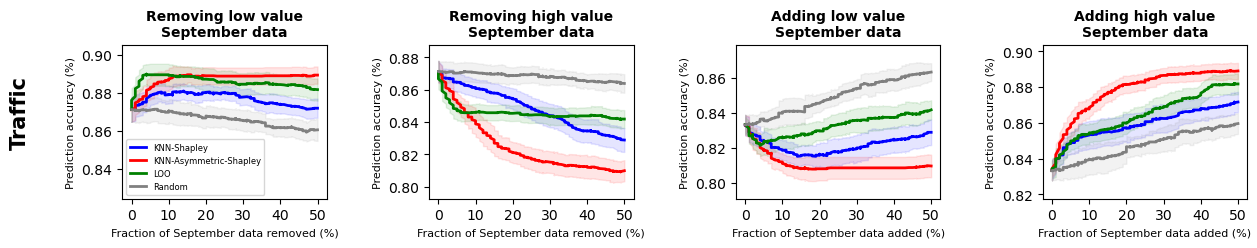

In [11]:
# Plot final plot
import matplotlib.pyplot as plt

final_plot_avg(remove_high_avg, remove_low_avg, add_high_avg, 
               add_low_avg, shap_vals_algo_lst, remove_add_ratio = 50,
               xticks=[0, 10, 20, 30, 40, 50],
               root_dir='experiments/sequential data valuation/traffic 10 random splits/experiment_2/',
               experiment='ex2',
               dataset='Traffic', imbalance=False)